In [81]:
from pathlib import Path
import pandas as pd
from CTL.causal_tree_learn import CausalTree
from CTL.causal_learn_forest import CausalTreeLearnForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from dfply import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t

In [2]:
%load_ext autoreload
%autoreload 2
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

## パラメータの設定

In [3]:
np.random.seed(42)
result_dir_path = Path('result')

if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## 関数の定義

In [120]:
def t_test(x, mu=0, alpha = 0.95):
    
    if not type(x) is np.ndarray:
        x = np.array(x)
    
    x_mean = x.mean()

    # numpyのデフォルトでは標準偏差なため,
    # 引数ddof=1を指定して不偏標準偏差とする
    x_std = x.std(ddof=1)

    # t値の導出
    t_value = (x_mean-mu) / (x_std / np.sqrt(x.size))

    # 自由度n-1の確率密度関数
    p_value = t.cdf(x=t_value, df=x.size-1)
    if t_value > 0:
        p_value = 1 - p_value

    intervals = t.interval(alpha=alpha, df=x.size-1)

    print('標本平均 = {:.2f}, 不偏標準偏差 = {:.2f}'.format(x_mean, x_std))
    print('p値 = {:.2f}%'.format(p_value))
    print('t値 = {:.2f}'.format(t_value))
    print('{}%のt値の範囲:({:.2f}, {:.2f})'.format(
        int(alpha*100),
        intervals[0],
        intervals[1]
    ))

## NSWデータの分析

### データの取得

In [4]:
nswdw_data = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')
cps1_data = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')

In [5]:
nswdw_data.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


### データの加工

In [6]:
cps1_nsw_data = nswdw_data >> filter_by(
    X.treat == 1
) >> bind_rows(
    cps1_data
)
cps1_nsw_data.reset_index(inplace=True, drop=True)

### CausalTreeによる効果検証

#### 理想的なデータの効果検証

In [173]:
target_data = nswdw_data >> select(~X.data_id)
y_name = 're78'
z_name = 'treat'

Y_data = target_data[y_name].values
Z_data = target_data[z_name].values
X_data = target_data.drop(columns=[y_name, z_name])
x_names = X_data.columns.tolist()
X_data = X_data.values

In [180]:
ctl = CausalTree(val_honest=True)
ctl.fit(X_data, Y_data, Z_data)
ctl.prune()
predict_values = ctl.predict(X_data)

In [181]:
t_test(predict_values, mu=0, alpha=0.95)

標本平均 = 1325.40, 不偏標準偏差 = 2892.19
p値 = 0.00%
t値 = 9.67
95%のt値の範囲:(-1.97, 1.97)


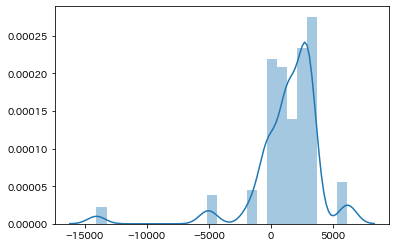

In [182]:
sns.distplot(predict_values)

In [183]:
ctl.plot_tree(
    features=x_names, 
    filename=result_dir_path.joinpath('causal_tree_nswd').__str__(),
    show_effect=True
)

#### 恣意的な割り当てデータの効果検証

In [184]:
target_data = cps1_nsw_data >> select(~X.data_id)
y_name = 're78'
z_name = 'treat'

Y_data = target_data[y_name].values
Z_data = target_data[z_name].values
X_data = target_data.drop(columns=[y_name, z_name])
X_data = X_data.values

In [189]:
ctl = CausalTree(val_honest=True)
ctl.fit(X_data, Y_data, Z_data)
ctl.prune()
predict_values = ctl.predict(X_data)

In [190]:
t_test(predict_values, mu=0, alpha=0.95)

標本平均 = -7701.39, 不偏標準偏差 = 4664.28
p値 = 0.00%
t値 = -210.01
95%のt値の範囲:(-1.96, 1.96)


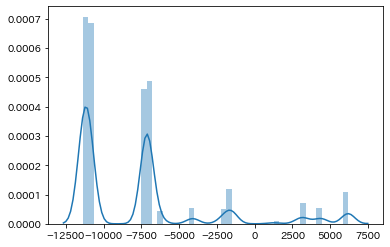

In [191]:
sns.distplot(predict_values)

In [192]:
ctl.plot_tree(
    features=x_names, 
    filename=result_dir_path.joinpath('causal_tree_cps').__str__(),
    show_effect=True
)

#### 極端な偏りがあるデータを取り除いたデータの効果検証

In [17]:
target_data = cps1_nsw_data >> select(~X.data_id)
y_name = 're78'
z_name = 'treat'

Z_data = target_data[z_name].values
X_data = target_data.drop(columns=[y_name, z_name])

In [18]:
model = LogisticRegression(
    penalty='l1', 
    max_iter=10000,
    solver='liblinear',
    random_state=42
)
model.fit(X_data, Z_data)
ps_scores = model.predict_proba(X_data)[:, 1]

In [19]:
learning_data = target_data.copy()
learning_data['ps_score'] = ps_scores

learning_data = learning_data >> filter_by(X.ps_score >= 0.1, X.ps_score <= 0.9)

Y_data = learning_data[y_name].values
Z_data = learning_data[z_name].values
X_data = learning_data.drop(columns=[y_name, z_name])
X_data = X_data.values

In [20]:
ctl = CausalTree(magnitude=False)
ctl.fit(X_data, Y_data, Z_data)
ctl.prune()
predict_values = ctl.predict(X_data)

In [21]:
print('平均値：{:.0f}, 中央値:{:.0f}, 標準偏差:{}'.format(
    np.mean(predict_values),
    np.median(predict_values),
    np.std(predict_values)
))

平均値：1716, 中央値:133, 標準偏差:4145.317807905444


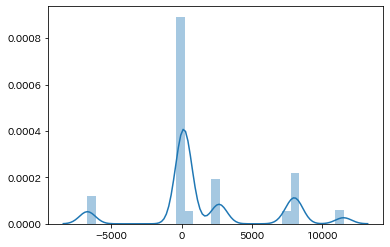

In [22]:
sns.distplot(predict_values)

In [179]:
ctl.plot_tree(
    features=x_names, 
    filename=result_dir_path.joinpath('causal_tree_cps_cut').__str__(),
    show_effect=True
)

## Gameデータの分析

### データの取得

In [191]:
game_data = pd.read_csv('https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv')

### 効果検証

In [199]:
Y_data = game_data['gamesecond'].values
Z_data = game_data['cm_dummy'].values
X_data = game_data >> select(
    X.TVwatch_day, X.age, X.sex, X.marry_dummy, X.child_dummy,
    X.inc, X.pmoney, X.area_kanto, X.area_tokai, X.area_keihanshin, 
    X.job_dummy1, X.job_dummy2, X.job_dummy3, X.job_dummy4,
    X.job_dummy5, X.job_dummy6, X.job_dummy7, X.fam_str_dummy1, 
    X.fam_str_dummy2, X.fam_str_dummy3, X.fam_str_dummy4
)
x_names = X_data.columns.tolist()
X_data = X_data.values

In [200]:
ctl = CausalTree(magnitude=False)
ctl.fit(X_data, Y_data, Z_data)
ctl.prune()
predict_values = ctl.predict(X_data)

In [201]:
print('平均値：{:.0f}, 中央値:{:.0f}, 標準偏差:{}'.format(
    np.mean(predict_values),
    np.median(predict_values),
    np.std(predict_values)
))

平均値：2166, 中央値:0, 標準偏差:24240.38514775589


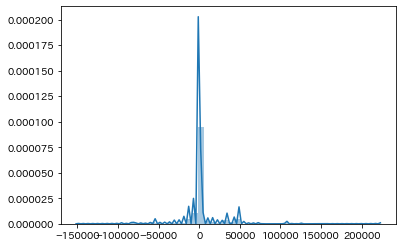

In [202]:
sns.distplot(predict_values)

In [203]:
ctl.plot_tree(
    features=x_names, 
    filename=result_dir_path.joinpath('causal_tree_game').__str__(),
    show_effect=True
)

#### 傾向スコアにより抽出したデータの効果検証

In [211]:
Z_data = game_data['cm_dummy'].values
X_data = game_data >> select(
    X.TVwatch_day, X.age, X.sex, X.marry_dummy, X.child_dummy,
    X.inc, X.pmoney, X.area_kanto, X.area_tokai, X.area_keihanshin, 
    X.job_dummy1, X.job_dummy2, X.job_dummy3, X.job_dummy4,
    X.job_dummy5, X.job_dummy6, X.job_dummy7, X.fam_str_dummy1, 
    X.fam_str_dummy2, X.fam_str_dummy3, X.fam_str_dummy4
)
x_names = X_data.columns.tolist()

In [205]:
model = LogisticRegression(
    penalty='l1', 
    max_iter=10000,
    solver='liblinear',
    random_state=42
)
model.fit(X_data, Z_data)
ps_scores = model.predict_proba(X_data)[:, 1]

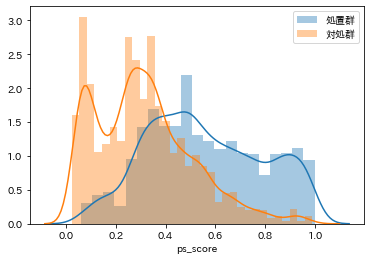

In [218]:
plot_data = game_data >> select(
    X.cm_dummy, X.TVwatch_day, X.age, X.sex, X.marry_dummy, X.child_dummy,
    X.inc, X.pmoney, X.area_kanto, X.area_tokai, X.area_keihanshin, 
    X.job_dummy1, X.job_dummy2, X.job_dummy3, X.job_dummy4,
    X.job_dummy5, X.job_dummy6, X.job_dummy7, X.fam_str_dummy1, 
    X.fam_str_dummy2, X.fam_str_dummy3, X.fam_str_dummy4
)
plot_data['ps_score'] = ps_scores

z1_data = plot_data >> filter_by(X.cm_dummy == 1)
z0_data = plot_data >> filter_by(X.cm_dummy == 0)
sns.distplot(z1_data['ps_score'], label='処置群')
sns.distplot(z0_data['ps_score'], label='対処群')
plt.legend()

In [220]:
learning_data = game_data.copy()
learning_data['ps_score'] = ps_scores

learning_data = learning_data >> filter_by(X.ps_score >= 0.1, X.ps_score <= 0.9)

Y_data = learning_data['gamesecond'].values
Z_data = learning_data['cm_dummy'].values
X_data = learning_data >> select(
    X.TVwatch_day, X.age, X.sex, X.marry_dummy, X.child_dummy,
    X.inc, X.pmoney, X.area_kanto, X.area_tokai, X.area_keihanshin, 
    X.job_dummy1, X.job_dummy2, X.job_dummy3, X.job_dummy4,
    X.job_dummy5, X.job_dummy6, X.job_dummy7, X.fam_str_dummy1, 
    X.fam_str_dummy2, X.fam_str_dummy3, X.fam_str_dummy4
)
x_names = X_data.columns.tolist()
X_data = X_data.values

In [221]:
ctl = CausalTree(magnitude=False)
ctl.fit(X_data, Y_data, Z_data)
ctl.prune()
predict_values = ctl.predict(X_data)

In [222]:
print('平均値：{:.0f}, 中央値:{:.0f}, 標準偏差:{}'.format(
    np.mean(predict_values),
    np.median(predict_values),
    np.std(predict_values)
))

平均値：-1067, 中央値:0, 標準偏差:24257.205464702747


In [225]:
ctl.plot_tree(
    features=x_names, 
    filename=result_dir_path.joinpath('causal_tree_game_cut').__str__(),
    show_effect=True
)